# Machine Learning Classifier
Assign scores to predict the potential improvement in safety by installing smoke detectors in that area

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium

%matplotlib inline
pd.set_option('display.max_columns',500)
sns.set()

In [2]:
nfirs = pd.read_csv('../data/02_interim/03_nfirs_geoids.csv',dtype={'geoid':str})

C:\Users\thwhi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (2,3,6,16,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1. Read in data
2. Look at the descriptive statistics of the label (in this case smoke alarm presence)
2. Data cleaning
3. feature engineering
4. initial classifier (logistic regression)

How to determine if a given geographic area is less likely to have fire alarms? You can look at the number of fires, and the fraction of those fires which have smoke alarms in them. Seems easy enough.

The big problem is that it seems that the fire alarm data isn't always filled in. Either it's unknown for a lot of fires, or perhaps some fire departments just don't fill it in.

In [73]:
def null_counts(df):
    null_df = pd.DataFrame(df.isnull().sum(),columns=['null_count'])
    null_df['null_fraction'] = null_df['null_count'] / df.shape[0]
    null_df = null_df.sort_values('null_count',ascending=False)
    return null_df

In [74]:
null_counts(nfirs)

,null_count,null_fraction
aes_fail,1955785,0.998305
no_spr_op,1935953,0.988182
aes_oper,1932703,0.986523
aes_type,1929975,0.985130
det_fail,1904639,0.972198
det_effect,1682810,0.858968
det_operat,1500748,0.766037
det_type,1497389,0.764323
det_power,1492512,0.761833
oth_death,1188360,0.606583


In [3]:
nfirs.head()

,rcp2_id,state,fdid,inc_no,city,street,zip5,inc_date,oth_inj,oth_death,exp_no,inc_type,prop_loss,cont_loss,tot_loss,detector,det_type,det_power,det_operat,det_effect,det_fail,aes_pres,aes_type,aes_oper,no_spr_op,aes_fail,geoid,match,match_type,tiger_line_id,tiger_line_side,lon,lat
0,rcp2_id1,AK,11100,211,JUNEAU,1700 ANGUS WAY,99801,2009-01-03,0.0,0.0,0.0,111,20000.0,5000.0,25000.0,1,1,1,2,1,NaN,N,NaN,NaN,NaN,NaN,02110000500,Match,Exact,190964136.0,R,-134.42440,58.306507
1,rcp2_id2,AK,11100,470,JUNEAU,3221 PIONEER AVE,99801,2009-01-06,0.0,0.0,0.0,114,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,02110000600,Match,Exact,190966361.0,R,-134.43314,58.292686
2,rcp2_id3,AK,11100,556,JUNEAU,10231 HERON WAY,99801,2009-01-06,0.0,0.0,0.0,111,20000.0,5000.0,25000.0,N,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,02110000100,Match,Exact,190962538.0,R,-134.60330,58.402610
3,rcp2_id4,AK,11100,1315,JUNEAU,6590 GLACIER HWY,99801,2009-01-13,0.0,0.0,0.0,113,200.0,20.0,220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,02110000400,Match,Exact,190963741.0,R,-134.51932,58.358955
4,rcp2_id5,AK,11100,2151,JUNEAU,6590 GLACIER HWY,99801,2009-01-21,0.0,0.0,0.0,111,35000.0,5000.0,40000.0,N,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,02110000400,Match,Exact,190963741.0,R,-134.51932,58.358955


In [4]:
nfirs['detector'].value_counts(dropna=False)

NaN    925886
1      466610
U      301345
N      265265
Name: detector, dtype: int64

About 50% of the entries are NaN, and then another 15% are listed as U. So it's unknown whether there's a fire alarm in about 65% of the homes where there are fires.

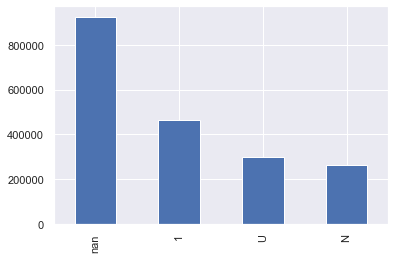

In [5]:
nfirs['detector'].value_counts(dropna=False).plot.bar()

In [55]:
# So, I want to aggregate the smoke detector statistics by geoid

geoids = pd.crosstab(nfirs['geoid'],nfirs['detector'].fillna('nan'))

In [56]:
geoids['ratio_1_N'] = geoids['1'] / (geoids['1'] + geoids['N']) 

In [57]:
geoids['tot_fires'] = geoids[['1','N','U','nan']].sum(axis=1)
geoids['ratio_tot'] = geoids['1'] / geoids['tot_fires']

In [58]:
cols_to_add = ['geoid','city','state','fdid']
geoids = (geoids.reset_index()
          .merge(nfirs[cols_to_add].drop_duplicates(subset='geoid'),
                 how='left',left_on='geoid',right_on='geoid')
          .set_index('geoid')
          .sort_index())

In [59]:
geoids.sort_values(['ratio_tot','1'],ascending=False).head()

,1,N,U,nan,ratio_1_N,tot_fires,ratio_tot,city,state,fdid
geoid,,,,,,,,,,
42101005600,27,0,0,0,1.0,27,1.0,PHILADELPHIA,PA,PA51001
42101012201,24,0,0,0,1.0,24,1.0,PHILADELPHIA,PA,PA51001
42101000100,19,0,0,0,1.0,19,1.0,PHILADELPHIA,PA,PA51001
42101000401,18,0,0,0,1.0,18,1.0,PHILADELPHIA,PA,PA51001
39035109701,17,0,0,0,1.0,17,1.0,CLEVELAND,OH,OH18027


In [10]:
geoids.sort_values(['ratio','N'],ascending=False).head()

,1,N,U,nan,ratio,city,state,fdid
geoid,,,,,,,,
01001020500,16,0,6,39,1.0,Prattville,AL,401
01001020801,4,0,1,3,1.0,Prattville,AL,401
01001020802,3,0,0,5,1.0,Prattville,AL,401
01003010400,1,0,4,4,1.0,Bay Minette,AL,501
01003010903,3,0,7,3,1.0,Loxley,AL,00507


So, it appears that some areas have almost no locations where fires occur with a smoke detector, while in other locations almost every location with a fire has a smoke detector.

For now, I won't worry too much about the possible data provenance and quality issues, and just create a classifier using the available data to see what it looks like.

One way to do that though would be to groupby fire department id to see if specific fire departments tend to mark a surprising number of fires as being in areas without a smoke detector. Though it'll always be difficult to determine if it's just an area that doesn't have many smoke detectors or if it's that a given fire department is less diligent about checking whether there's a smoke detector.

1. Add leading zeros to the fdid column to ensure that all of them have a correct, 5-digit fdid
2. Concatenate the 2 letter state code to the start of each fdid so that they are now unique identifiers

In [65]:
nfirs['fdid'] = nfirs['state'] + nfirs['fdid'].astype(str).str.zfill(5)

fdids = pd.crosstab(nfirs['fdid'],nfirs['detector'].fillna('nan'))

fdids['tot_fires'] = fdids[['1','N','U','nan']].sum(axis=1)

fdids['ratio_1_N'] = fdids['1'] / (fdids['1'] + fdids['N'])
fdids['ratio_tot'] = fdids['1'] / fdids['tot_fires']
cols_to_add = ['fdid','city','state']
fdids = (fdids.reset_index()
          .merge(nfirs[cols_to_add].drop_duplicates(subset='fdid'),
                 how='left',left_on='fdid',right_on='fdid'))

fdids = fdids.set_index('fdid')

In [67]:
fdids[fdids['tot_fires']>100].sort_values(['ratio_tot','tot_fires'],ascending=[True,False]).head()

,1,N,U,nan,tot_fires,ratio_1_N,ratio_tot,city,state
fdid,,,,,,,,,
MSMS42001,0,0,225,192,417,NaN,0.0,Greenwood,MS
MOMO11102,0,0,309,64,373,NaN,0.0,Mineral Point,MO
NYNY30055,0,1,5,193,199,0.0,0.0,ROOSEVELT,NY
VAVA78000,0,8,95,72,175,0.0,0.0,South Boston,VA
NYNY44020,0,0,0,155,155,NaN,0.0,AIRMONT,NY


In [47]:
fdids[fdids['tot_fires']>100].sort_values(['ratio','tot_fires'],ascending=[False,False]).head()

,1,N,U,nan,tot_fires,ratio,city,state
fdid,,,,,,,,
NY36059,7,0,0,390,397,1.0,MONROE,NY
CT02210,27,0,0,321,348,1.0,ROCKY HILL,CT
NJ16050,2,0,1,259,262,1.0,Little Falls,NJ
NJ02480,11,0,16,208,235,1.0,Ramsey,NJ
NY52061,2,0,6,214,222,1.0,LINDENHURST,NY


In [60]:
geoids.head()

,1,N,U,nan,ratio_1_N,tot_fires,ratio_tot,city,state,fdid
geoid,,,,,,,,,,
01001020100,6,2,1,4,0.750000,13,0.461538,Prattville,AL,AL00401
01001020200,3,3,2,9,0.500000,17,0.176471,Prattville,AL,AL00401
01001020300,5,6,2,12,0.454545,25,0.200000,Prattville,AL,AL00401
01001020400,3,6,6,7,0.333333,22,0.136364,Prattville,AL,AL00401
01001020500,16,0,6,39,1.000000,61,0.262295,Prattville,AL,AL00401


Ok, let's take a look at some descriptive statistics about smoke alarms by geoid

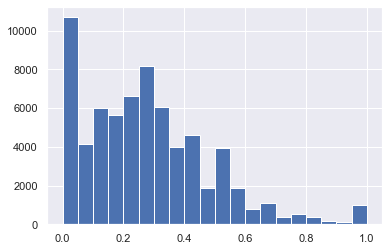

In [62]:
# Histogram of the ratio between confirmed smoke alarms and total fires
geoids['ratio_tot'].hist(bins=20)

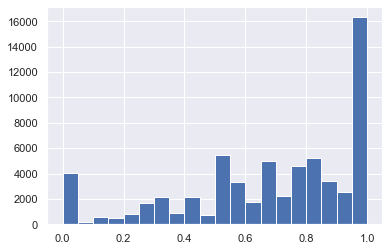

In [64]:
# Ratio between confirmed smoke alarms and just confirmed homes with or without smoke alarms. As you can see, it's markedly different than the previous histogram
geoids['ratio_1_N'].hist(bins=20)

Now let's look at it by specific fire department

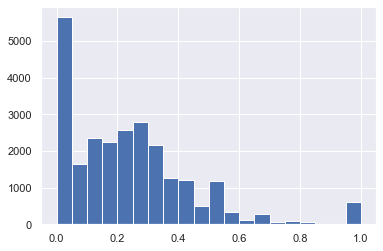

In [69]:
fdids['ratio_tot'].hist(bins=20)

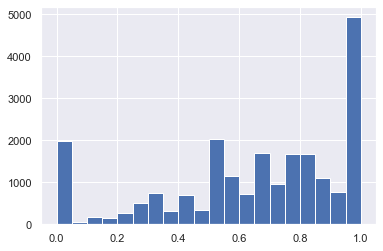

In [70]:
fdids['ratio_1_N'].hist(bins=20)

In [68]:
fdids.head()

,1,N,U,nan,tot_fires,ratio_1_N,ratio_tot,city,state
fdid,,,,,,,,,
AKAK11100,73,30,27,129,259,0.708738,0.281853,JUNEAU,AK
AKAK12100,7,0,2,17,26,1.000000,0.269231,HAINES,AK
AKAK12111,0,0,1,0,1,NaN,0.000000,Haines,AK
AKAK12150,0,1,1,3,5,0.000000,0.000000,HAINES,AK
AKAK12151,0,0,0,1,1,NaN,0.000000,Klukwan,AK


From looking at the above charts, it's quite clear that the data on smoke alarms is somewhat questionable. But it's all we've got I suppose, so we'll go with it.

In [77]:
(fdids['U'].sum() + fdids['nan'].sum()) / fdids['tot_fires'].sum()

0.6264332670065024

As you can see, 63% of the detector field was either not entered at all, or a value of undetermined was entered.

In [71]:
geoids['ratio_tot'].describe()

count    68129.000000
mean         0.272959
std          0.209422
min          0.000000
25%          0.117647
50%          0.250000
75%          0.391304
max          1.000000
Name: ratio_tot, dtype: float64

In [72]:
geoids.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68129 entries, 01001020100 to 56045951300
Data columns (total 10 columns):
1            68129 non-null int64
N            68129 non-null int64
U            68129 non-null int64
nan          68129 non-null int64
ratio_1_N    63511 non-null float64
tot_fires    68129 non-null int64
ratio_tot    68129 non-null float64
city         68129 non-null object
state        68126 non-null object
fdid         68126 non-null object
dtypes: float64(2), int64(5), object(3)
memory usage: 5.7+ MB


In [80]:
geoids.head()

,1,N,U,nan,ratio_1_N,tot_fires,ratio_tot,city,state,fdid
geoid,,,,,,,,,,
01001020100,6,2,1,4,0.750000,13,0.461538,Prattville,AL,AL00401
01001020200,3,3,2,9,0.500000,17,0.176471,Prattville,AL,AL00401
01001020300,5,6,2,12,0.454545,25,0.200000,Prattville,AL,AL00401
01001020400,3,6,6,7,0.333333,22,0.136364,Prattville,AL,AL00401
01001020500,16,0,6,39,1.000000,61,0.262295,Prattville,AL,AL00401


# County Level Data aggregation

In [82]:
nfirs['county_geoid'] = '0500000US' + nfirs['geoid'].str[:5]

In [85]:
counties = pd.crosstab(nfirs['county_geoid'],nfirs['detector'].fillna('nan'))
counties['ratio_1_N'] = counties['1'] / (counties['1'] + counties['N']) 

counties['tot_fires'] = counties[['1','N','U','nan']].sum(axis=1)
counties['ratio_tot'] = counties['1'] / counties['tot_fires']

cols_to_add = ['county_geoid','city','state','fdid']
counties = (counties.reset_index()
          .merge(nfirs[cols_to_add].drop_duplicates(subset='county_geoid'),
                 how='left',left_on='county_geoid',right_on='county_geoid')
          .set_index('county_geoid')
          .sort_index())

counties.sort_values(['ratio_tot','1'],ascending=False).head()

,1,N,U,nan,ratio_1_N,tot_fires,ratio_tot,city,state,fdid
county_geoid,,,,,,,,,,
0500000US27049,5,0,0,0,1.0,5,1.0,Zumbrota,MN,MNMN25108
0500000US27043,4,0,0,0,1.0,4,1.0,Winnebago,MN,MNMN22111
0500000US20063,3,0,0,0,1.0,3,1.0,Grainfield,KS,KSKSGO302
0500000US27133,2,0,0,0,1.0,2,1.0,Luverne,MN,MNMN67105
0500000US46003,2,0,0,0,1.0,2,1.0,Plankinton,SD,SDSD10001


In [87]:
counties[counties['tot_fires']>100].sort_values(['ratio_tot','tot_fires'],ascending=[False,False]).head()

,1,N,U,nan,ratio_1_N,tot_fires,ratio_tot,city,state,fdid
county_geoid,,,,,,,,,,
0500000US24031,1851,127,301,98,0.935794,2377,0.778713,POOLESVILLE,MD,MDMD10014
0500000US51041,1947,144,276,175,0.931133,2542,0.765932,CHESTER,VA,VAVA04100
0500000US41051,2064,467,154,128,0.815488,2813,0.733736,Gresham,OR,OROR00144
0500000US42101,8145,2197,1345,2,0.787565,11689,0.696809,PHILADELPHIA,PA,PAPA51001
0500000US41005,1150,186,223,207,0.860778,1766,0.651189,BORING,OR,OROR00033


In [90]:
counties['ratio_score'] = (counties['ratio_tot'] * 100).round(0)

In [91]:
counties.head()

,1,N,U,nan,ratio_1_N,tot_fires,ratio_tot,city,state,fdid,ratio_score
county_geoid,,,,,,,,,,,
0500000US01001,51,22,32,97,0.698630,202,0.252475,Prattville,AL,ALAL00401,25.0
0500000US01003,229,90,194,229,0.717868,742,0.308625,Bay Minette,AL,ALAL00501,31.0
0500000US01005,10,7,29,6,0.588235,52,0.192308,Clayton,AL,ALAL00602,19.0
0500000US01007,5,0,6,2,1.000000,13,0.384615,RANDOLPH,AL,ALAL00708,38.0
0500000US01009,48,17,56,59,0.738462,180,0.266667,Oneonta,AL,ALAL00801,27.0


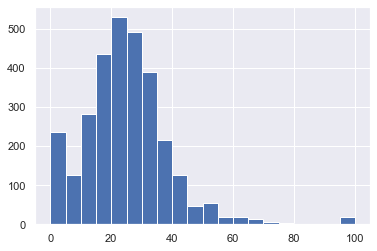

In [95]:
counties['ratio_score'].hist(bins=20)

In [96]:
with open('../data/01_raw/us_counties_20m_topo.json','r') as f:
    county_geo = json.load(f)

In [106]:
counties.get('0500000US01001','hello')

'hello'

In [107]:
import branca

In [100]:
county_geo['objects']['us_counties_20m']['geometries'][0]['id']

'0500000US01001'

In [112]:
counties.head()

,1,N,U,nan,ratio_1_N,tot_fires,ratio_tot,city,state,fdid,ratio_score
county_geoid,,,,,,,,,,,
0500000US01001,51,22,32,97,0.698630,202,0.252475,Prattville,AL,ALAL00401,25.0
0500000US01003,229,90,194,229,0.717868,742,0.308625,Bay Minette,AL,ALAL00501,31.0
0500000US01005,10,7,29,6,0.588235,52,0.192308,Clayton,AL,ALAL00602,19.0
0500000US01007,5,0,6,2,1.000000,13,0.384615,RANDOLPH,AL,ALAL00708,38.0
0500000US01009,48,17,56,59,0.738462,180,0.266667,Oneonta,AL,ALAL00801,27.0


In [115]:
'0500000US01001' == '0500000US01001'

True

In [ ]:
syle_function()

In [114]:
county_geo

{'type': 'Topology',
 'transform': {'scale': [0.035896170617061705, 0.005347309530953095],
  'translate': [-179.14734, 17.884813]},
 'objects': {'us_counties_20m': {'type': 'GeometryCollection',
   'geometries': [{'type': 'Polygon',
     'arcs': [[0, 1, 2, 3, 4]],
     'id': '0500000US01001',
     'properties': {'style': {'fillOpacity': 0.5,
       'weight': 0,
       'fillColor': '#ffffcc'}}},
    {'type': 'Polygon',
     'arcs': [[5, 6, 7, 8, 9, 10]],
     'id': '0500000US01009',
     'properties': {'style': {'fillOpacity': 0.5,
       'weight': 0,
       'fillColor': '#ffffcc'}}},
    {'type': 'Polygon',
     'arcs': [[11, 12, 13, 14, 15]],
     'id': '0500000US01017',
     'properties': {'style': {'fillOpacity': 0.5,
       'weight': 0,
       'fillColor': '#ffffcc'}}},
    {'type': 'Polygon',
     'arcs': [[16, 17, -3, 18, 19, 20, 21]],
     'id': '0500000US01021',
     'properties': {'style': {'fillOpacity': 0.5,
       'weight': 0,
       'fillColor': '#ffffcc'}}},
    {'type': 

In [120]:
import folium
import branca

colorscale = branca.colormap.linear.YlOrRd_09.scale(0, 100)
colorscale.caption = 'Percent of homes without fire alarms'

county_alarm_ratio = 100 - counties['ratio_score']

def style_function(feature):
    alarm_ratio = county_alarm_ratio.get(feature['id'],None)
    return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor': '#black' if alarm_ratio is None else colorscale(alarm_ratio)        
    }

m = folium.Map(
    location=[48, -102],
    tiles='cartodbpositron',
    zoom_start=3
)

with open('../data/01_raw/us_counties_20m_topo.json','r') as f:
    county_geo = json.load(f)

folium.TopoJson(
    county_geo,
    'objects.us_counties_20m',
    style_function=style_function
).add_to(m)

# folium.TopoJson(
#     json.loads(requests.get(county_geo).text),
#     'objects.us_counties_20m',
#     style_function=style_function
# ).add_to(m)

colorscale.add_to(m)

m

Ok, I was able to make a folium map using the topojson file of all the counties in the USA. I wasn't able to plug and play use a choropleth map because the geo_data file wasn't a geojson, but I'm going to see if I can get that working this time around.

In [121]:
counties.head()

,1,N,U,nan,ratio_1_N,tot_fires,ratio_tot,city,state,fdid,ratio_score
county_geoid,,,,,,,,,,,
0500000US01001,51,22,32,97,0.698630,202,0.252475,Prattville,AL,ALAL00401,25.0
0500000US01003,229,90,194,229,0.717868,742,0.308625,Bay Minette,AL,ALAL00501,31.0
0500000US01005,10,7,29,6,0.588235,52,0.192308,Clayton,AL,ALAL00602,19.0
0500000US01007,5,0,6,2,1.000000,13,0.384615,RANDOLPH,AL,ALAL00708,38.0
0500000US01009,48,17,56,59,0.738462,180,0.266667,Oneonta,AL,ALAL00801,27.0


In [137]:
len(all_county_ids)

3221

In [136]:
all_county_ids = [geo['id'] for geo in county_geo['objects']['us_counties_20m']['geometries']]
df_all_county_ids = pd.DataFrame(all_county_ids,columns=['county_geoid'])
df_all_county_ids = df_all_county_ids.merge(counties,how='left',left_on='county_geoid',right_index=True)

,county_geoid,1,N,U,nan,ratio_1_N,tot_fires,ratio_tot,city,state,fdid,ratio_score
0,0500000US01001,51.0,22.0,32.0,97.0,0.698630,202.0,0.252475,Prattville,AL,ALAL00401,25.0
1,0500000US01009,48.0,17.0,56.0,59.0,0.738462,180.0,0.266667,Oneonta,AL,ALAL00801,27.0
2,0500000US01017,26.0,27.0,25.0,49.0,0.490566,127.0,0.204724,Valley,AL,ALAL01208,20.0
3,0500000US01021,53.0,20.0,100.0,77.0,0.726027,250.0,0.212000,Verbena,AL,ALAL00407,21.0
4,0500000US01033,12.0,10.0,25.0,47.0,0.545455,94.0,0.127660,SHEFFIELD,AL,ALAL02001,13.0
5,0500000US01045,23.0,24.0,36.0,50.0,0.489362,133.0,0.172932,Enterprise,AL,ALAL01902,17.0
6,0500000US01051,73.0,39.0,112.0,69.0,0.651786,293.0,0.249147,Prattville,AL,ALAL00401,25.0
7,0500000US01065,10.0,10.0,11.0,3.0,0.500000,34.0,0.294118,Greensboro,AL,ALAL03601,29.0
8,0500000US01079,11.0,4.0,19.0,3.0,0.733333,37.0,0.297297,Moulton,AL,ALAL04201,30.0
9,0500000US01083,37.0,13.0,26.0,51.0,0.740000,127.0,0.291339,Athens,AL,ALAL04401,29.0


In [144]:
import folium
import branca

colorscale = branca.colormap.linear.YlOrRd_09.scale(0, 100)
colorscale.caption = 'Percent of homes without fire alarms'

county_alarm_ratio = 100 - counties['ratio_score']

m = folium.Map(
    location=[48, -102],
    tiles='cartodbpositron',
    zoom_start=3
)

with open('../data/01_raw/us_counties_20m_topo.json','r') as f:
    county_geo = json.load(f)

folium.Choropleth(
    geo_data = county_geo,
    name = 'choropleth',
    data = df_all_county_ids
#     key_on='feature.id',
#     fill_color='YlGn',
#     fill_opacity=0.7,
#     line_opacity=0.2
#     topojson = 'objects.us_counties_20m'
#     legend_name = 'Percent of homes without fire alarms'
).add_to(m)

m

# folium.TopoJson(
#     county_geo,
#     'objects.us_counties_20m',
#     style_function=style_function
# ).add_to(m)

# # folium.TopoJson(
# #     json.loads(requests.get(county_geo).text),
# #     'objects.us_counties_20m',
# #     style_function=style_function
# # ).add_to(m)

# colorscale.add_to(m)



ValueError: blue is not a valid ColorBrewer code

In [126]:
county_geo

{'type': 'Topology',
 'transform': {'scale': [0.035896170617061705, 0.005347309530953095],
  'translate': [-179.14734, 17.884813]},
 'objects': {'us_counties_20m': {'type': 'GeometryCollection',
   'geometries': [{'type': 'Polygon',
     'arcs': [[0, 1, 2, 3, 4]],
     'id': '0500000US01001'},
    {'type': 'Polygon', 'arcs': [[5, 6, 7, 8, 9, 10]], 'id': '0500000US01009'},
    {'type': 'Polygon',
     'arcs': [[11, 12, 13, 14, 15]],
     'id': '0500000US01017'},
    {'type': 'Polygon',
     'arcs': [[16, 17, -3, 18, 19, 20, 21]],
     'id': '0500000US01021'},
    {'type': 'Polygon', 'arcs': [[22, 23, 24, 25]], 'id': '0500000US01033'},
    {'type': 'Polygon',
     'arcs': [[26, 27, 28, 29, 30, 31]],
     'id': '0500000US01045'},
    {'type': 'Polygon',
     'arcs': [[32, 33, 34, -4, -18, 35]],
     'id': '0500000US01051'},
    {'type': 'Polygon',
     'arcs': [[36, 37, 38, 39, 40]],
     'id': '0500000US01065'},
    {'type': 'Polygon',
     'arcs': [[41, 42, 43, 44, -25, 45, 46]],
     '

In [127]:
county_geo['objects']['us_counties_20m']['geometries'][0]['id']

'0500000US01001'

In [140]:
df_all_county_ids.shape

(3221, 12)

In [130]:
all_county_ids

['0500000US01001',
 '0500000US01009',
 '0500000US01017',
 '0500000US01021',
 '0500000US01033',
 '0500000US01045',
 '0500000US01051',
 '0500000US01065',
 '0500000US01079',
 '0500000US01083',
 '0500000US01099',
 '0500000US01107',
 '0500000US01121',
 '0500000US02050',
 '0500000US02105',
 '0500000US02122',
 '0500000US02150',
 '0500000US02164',
 '0500000US02180',
 '0500000US02188',
 '0500000US02198',
 '0500000US05141',
 '0500000US05145',
 '0500000US06005',
 '0500000US06021',
 '0500000US06033',
 '0500000US06043',
 '0500000US06055',
 '0500000US06089',
 '0500000US06099',
 '0500000US06115',
 '0500000US08003',
 '0500000US08013',
 '0500000US08014',
 '0500000US08025',
 '0500000US08031',
 '0500000US08035',
 '0500000US08047',
 '0500000US12083',
 '0500000US12087',
 '0500000US12095',
 '0500000US12111',
 '0500000US12119',
 '0500000US12125',
 '0500000US13001',
 '0500000US13013',
 '0500000US13029',
 '0500000US13043',
 '0500000US13055',
 '0500000US13059',
 '0500000US13071',
 '0500000US13079',
 '0500000US1